In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pydicom
import json

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

# from imblearn.over_sampling import RandomOverSampler
import torch
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from helpers import get_ddsm_table, get_INBreast_table, get_VinDR_table, mask_image, run_intensity_functions, run_glcm_features, get_master_df, process_image
stage = 'process'
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
def run_tsne(features, labels):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(labels)
    tsne_results = tsne.fit_transform(features_scaled)
    tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
    tsne_df['Label'] = label_encoder.inverse_transform(numeric_labels)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Label", palette='Set1', s=100, alpha=0.7)
    plt.title("t-SNE of Image Features with Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Classes")
    plt.show()

    return tsne_df

In [3]:
def get_datasets(df):
    # Set Data Columns and Output Column
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(columns=['file_name', 'vendor', 'laterality', 'view_position', 'breast_density']))
    le = LabelEncoder()
    y = le.fit_transform(df['vendor'])

    # Set Train and Test data
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    input_size = X_train.shape[1]
    num_classes = len(np.unique(y))

    return input_size, num_classes, train_loader, test_loader, le

def build_model(input_size, num_classes):
    model = nn.Sequential(
    nn.Linear(input_size, 64), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),         
    nn.ReLU(),
    nn.Linear(32, num_classes) 
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    return model, criterion, optimizer

def train_model(model, optimizer, criterion, train_loader):
    train_metrics = {"loss": [], "accuracy": [], "f1": []}
    patience = 5
    min_delta = 0.001
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in tqdm(range(200)):
        if early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Training phase
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = accuracy_score(y_true_train, y_pred_train)
        epoch_f1 = f1_score(y_true_train, y_pred_train, average='weighted')


        train_metrics["loss"].append(epoch_loss)
        train_metrics["accuracy"].append(epoch_accuracy)
        train_metrics["f1"].append(epoch_f1)

        # Early stopping check
        if best_loss - epoch_loss > min_delta:
            best_loss = epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True
    
    return train_metrics

def test_model(model, test_loader):
    test_metrics = {"accuracy": [], "f1": []}
    model.eval()
    y_true_test, y_pred_test = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(preds.cpu().numpy())

    # Calculate metrics for test set
    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')

    test_metrics["accuracy"].append(test_accuracy)
    test_metrics["f1"].append(test_f1)

    return test_metrics

def plot_metrcis(train_metrics):
    epochs = range(1, len(train_metrics["loss"]) + 1)
    
    plt.figure(figsize=(6,6))
    plt.plot(epochs, train_metrics["loss"], label="Loss")
    plt.plot(epochs, train_metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, train_metrics["f1"], label="F1 Score")
    plt.title("Training Metrics")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_cm(model, test_loader, le):
    model.eval()
    y_true_test, y_pred_test = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_true_test, y_pred_test, target_names=le.classes_))

<h3>Load and Process Data</h3>

In [5]:
if(stage == 'Load Data'):
    ddsm_df = get_ddsm_table("../DDSM")
    INbreast_df = get_INBreast_table("../INbreast Release 1.0")
    vindr_df = get_VinDR_table("../VinDr")
    master_df = get_master_df(vindr_df, ddsm_df, INbreast_df)

    df_data = []
    for i in tqdm(range(len(master_df))):
        row = master_df.iloc[i]
        image_stats = {
            "file_name": row['full_path'],
            "vendor": row['Manufacturer'],
            "laterality": row['laterality'], 
            "view_position": row['view_position'],
            "breast_density": row['breast_density']    
        }
        pixel_array = pydicom.dcmread(row['full_path']).pixel_array
        breast_tissue_image = mask_image(pixel_array)
        intensity_stats, hist_features = run_intensity_functions(breast_tissue_image)
        image_stats.update(intensity_stats)
        image_stats.update(hist_features)
        glcm_stats = run_glcm_features(breast_tissue_image)
        image_stats.update(glcm_stats)
        df_data.append(image_stats)

    image_stats_df = pd.DataFrame(df_data)
    image_stats_df.to_csv('complete_stats_normalized_windows.csv', index=False)


100%|██████████| 2885/2885 [31:29<00:00,  1.53it/s]


<h3>Run TSNE analysis</h3>

In [8]:
if(stage == 'TSNE'):
    image_stats_df = pd.read_csv('complete_stats_normalized_windows.csv')


<h4>TSNE with all 60 Features</h4>

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


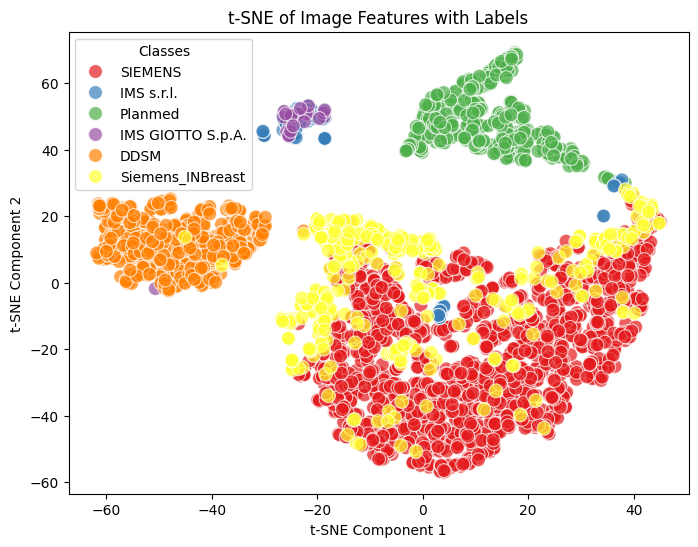

In [9]:
if(stage == 'TSNE'):
    feature_set = image_stats_df.iloc[:,5:]
    features = np.array(feature_set)
    labels = image_stats_df['vendor'].values
    results = run_tsne(features, labels)

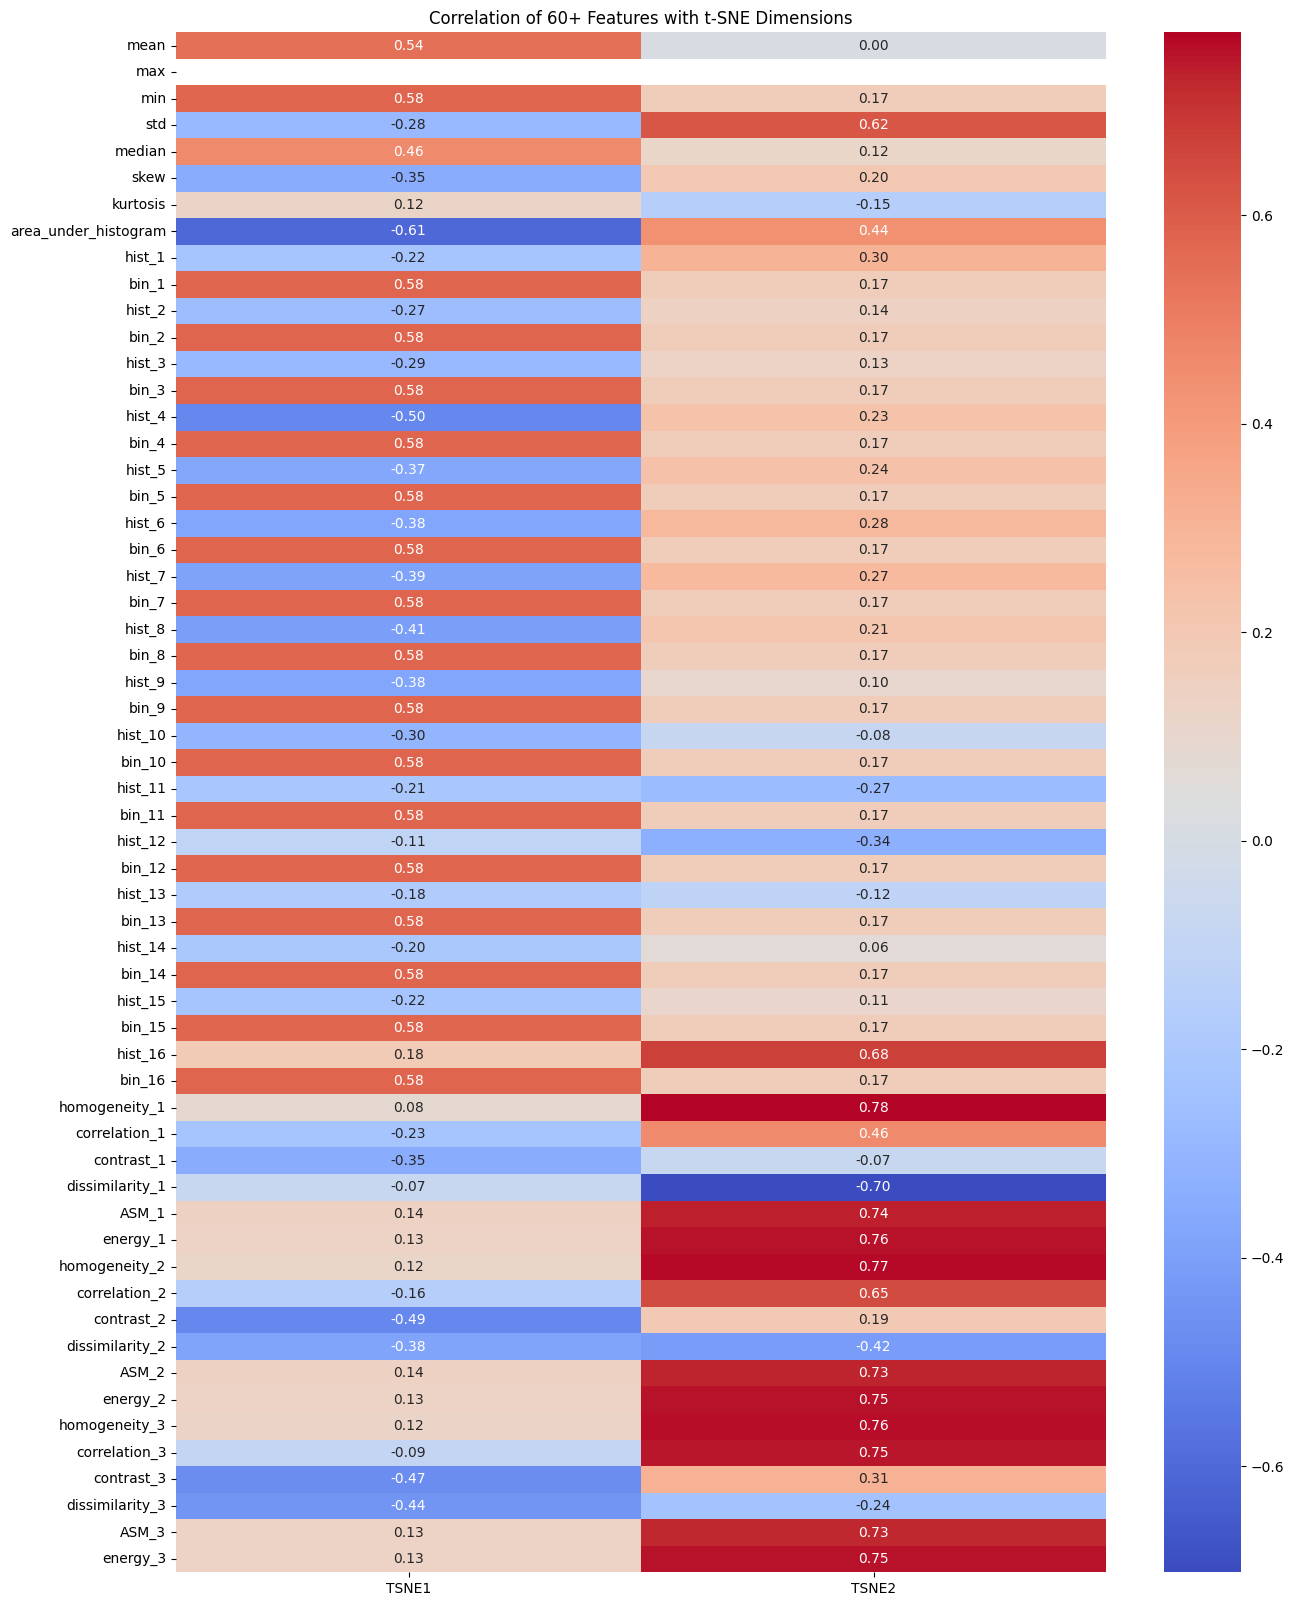

In [10]:
if(stage == 'TSNE'):
    correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
    tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
    plt.figure(figsize=(15, 20))
    sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation of 60+ Features with t-SNE Dimensions")
    plt.show()

<h4>TSNE with only minimum features</h4>

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


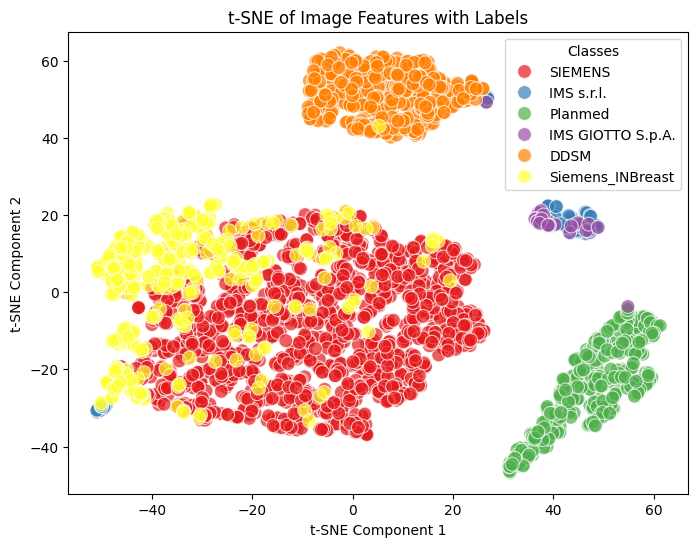

In [15]:
if(stage == 'TSNE'):
    min_features = ['mean', 'std', 'kurtosis', 'area_under_histogram', 'homogeneity_1', 'correlation_2', 'contrast_2', 'dissimilarity_3', 'ASM_2']
    feature_set = image_stats_df[min_features]
    features = np.array(feature_set)
    labels = image_stats_df['vendor'].values
    results = run_tsne(features, labels)

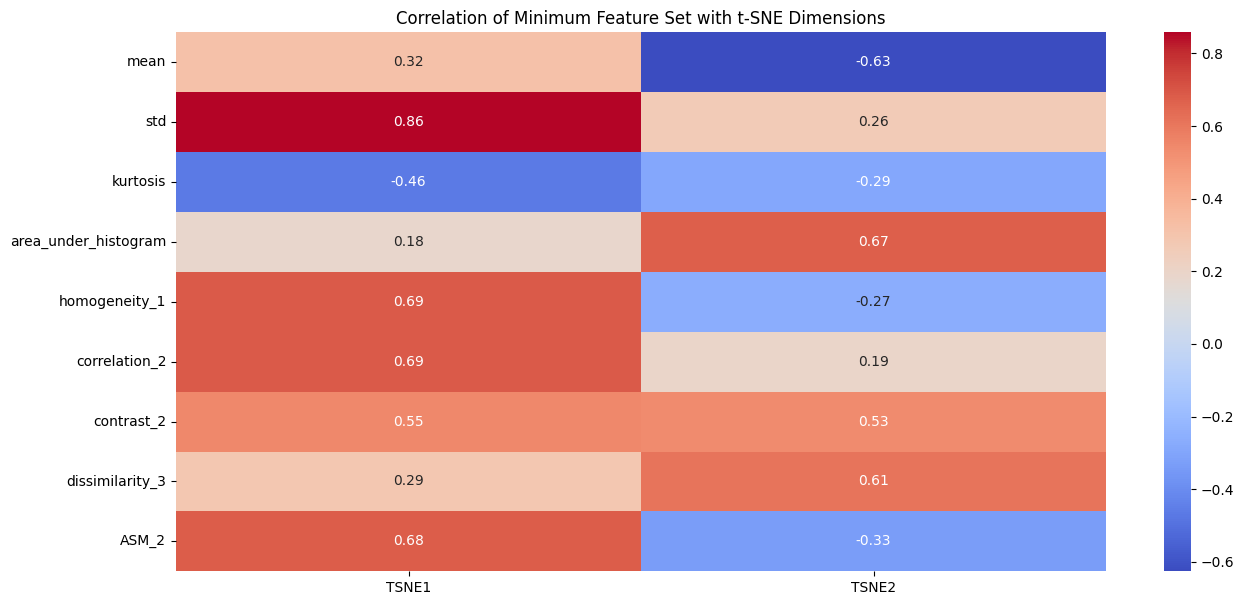

In [16]:
if(stage == 'TSNE'):
    correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
    tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
    plt.figure(figsize=(15, 7))
    sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation of Minimum Feature Set with t-SNE Dimensions")
    plt.show()

<h3>NN Classifier for Class Prediction</h3>

In [165]:
if(stage=='NN'):
    image_stats_df = pd.read_csv('complete_stats_normalized_windows.csv')
    image_stats_df['vendor'] = image_stats_df['vendor'].replace(['IMS s.r.l.', 'IMS GIOTTO S.p.A.'], 'IMS')
    df = image_stats_df.groupby('vendor').sample(n=70)
    
    input_size, num_classes, train_loader, test_loader, le = get_datasets(df)
    model, criterion, optimizer = build_model(input_size, num_classes)
    train_metrics = train_model(model, optimizer, criterion, train_loader)

    plot_metrcis(train_metrics)

 14%|█▍        | 29/200 [00:00<00:04, 39.04it/s]

Early stopping at epoch 30


In [173]:
if(stage == 'NN'):
    acc = []
    f1 = []
    for i in range(100):
        df = image_stats_df.groupby('vendor').sample(n=70)
        _,_,_, test_loader, le = get_datasets(df)
        test_metrics = test_model(model, test_loader)
        acc.append(test_metrics['accuracy'][0])
        f1.append(test_metrics['f1'][0])
        
    test_accuracy = np.mean(acc)
    test_f1 = np.mean(f1)
    
    print(f"Test Metrics - Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}") 

Test Metrics - Accuracy: 0.9583, F1: 0.9585


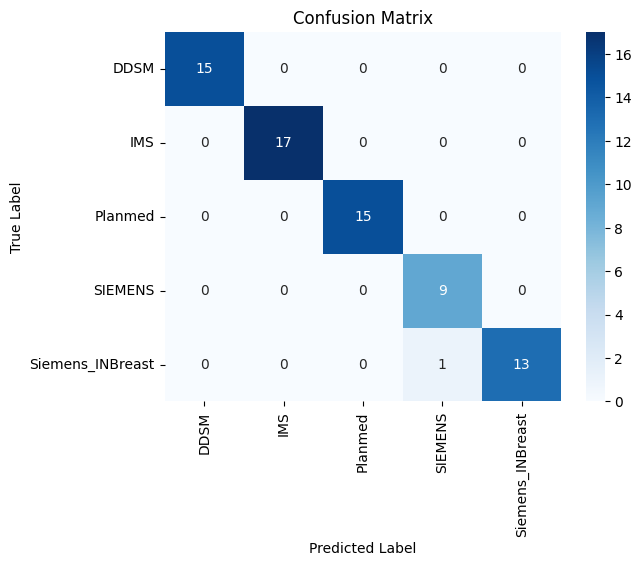

                  precision    recall  f1-score   support

            DDSM       1.00      1.00      1.00        15
             IMS       1.00      1.00      1.00        17
         Planmed       1.00      1.00      1.00        15
         SIEMENS       0.90      1.00      0.95         9
Siemens_INBreast       1.00      0.93      0.96        14

        accuracy                           0.99        70
       macro avg       0.98      0.99      0.98        70
    weighted avg       0.99      0.99      0.99        70



In [183]:
if(stage == 'NN'):
    plot_cm(model, test_loader, le)

In [184]:
if(stage == 'NN'):
    with open('Classification Results/normalized_no_processing_windows.json', 'w') as json_file:
        json.dump({'accuracy': test_accuracy, 'f1': test_f1}, json_file, indent=4)
    torch.save(model, 'model.pth')

<h3>Process Images</h3>

functions to apply:
clahe: https://scikit-image.org/docs/0.24.x/api/skimage.exposure.html#skimage.exposure.equalize_adapthist => Planmed
unsharpen: https://scikit-image.org/docs/stable/auto_examples/filters/plot_unsharp_mask.html => Planmed, IMS
wavelet denoising: https://scikit-image.org/docs/stable/auto_examples/filters/plot_denoise_wavelet.html => Siemens, Siemens INBreast

In [4]:
if(stage == 'process'):
    image_stats_df = pd.read_csv('complete_stats_normalized_windows.csv')
    image_stats_df = image_stats_df.iloc[:, 0:5]

In [5]:
if(stage=='process'):
    df_data = []
    for i in tqdm(range(len(image_stats_df))):
        image_stats = {}
        row = image_stats_df.iloc[i]
        pixel_array = pydicom.dcmread(row['file_name']).pixel_array
        breast_tissue_image = mask_image(pixel_array)
        vendor = row['vendor']
        img = process_image(breast_tissue_image, vendor) # -> Process the image
        intensity_stats, hist_features = run_intensity_functions(img)
        image_stats.update(intensity_stats)
        image_stats.update(hist_features)
        glcm_stats = run_glcm_features(img)
        image_stats.update(glcm_stats)
        df_data.append(image_stats)
    df_data = pd.DataFrame(df_data)
    image_stats_df = pd.concat([image_stats_df, df_data], axis=1)
    image_stats_df.to_csv('complete_stats_processed_windows.csv', index=False)

100%|██████████| 2885/2885 [1:13:09<00:00,  1.52s/it]


In [4]:
image_stats_df = pd.read_csv('complete_stats_processed_windows.csv')

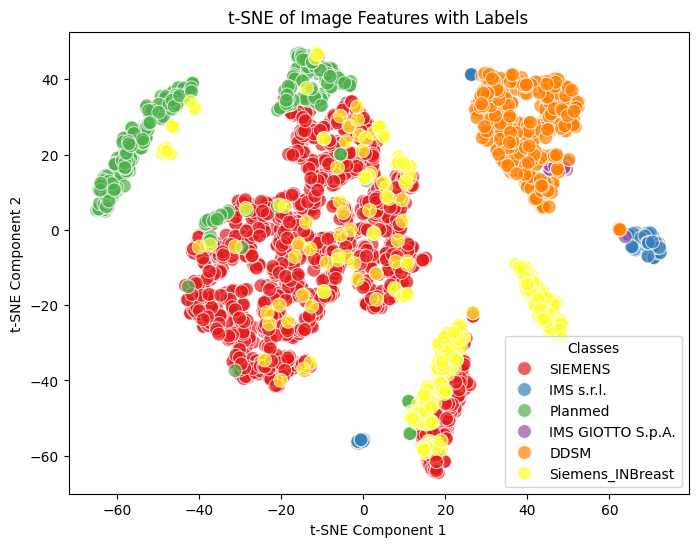

In [6]:
if(stage=='process'):
    min_features = ['mean', 'std', 'kurtosis', 'area_under_histogram', 'homogeneity_1', 'correlation_2', 'contrast_2', 'dissimilarity_3', 'ASM_2']
    feature_set = image_stats_df[min_features]   
    features = np.array(feature_set)
    labels = image_stats_df['vendor'].values
    results = run_tsne(features, labels)

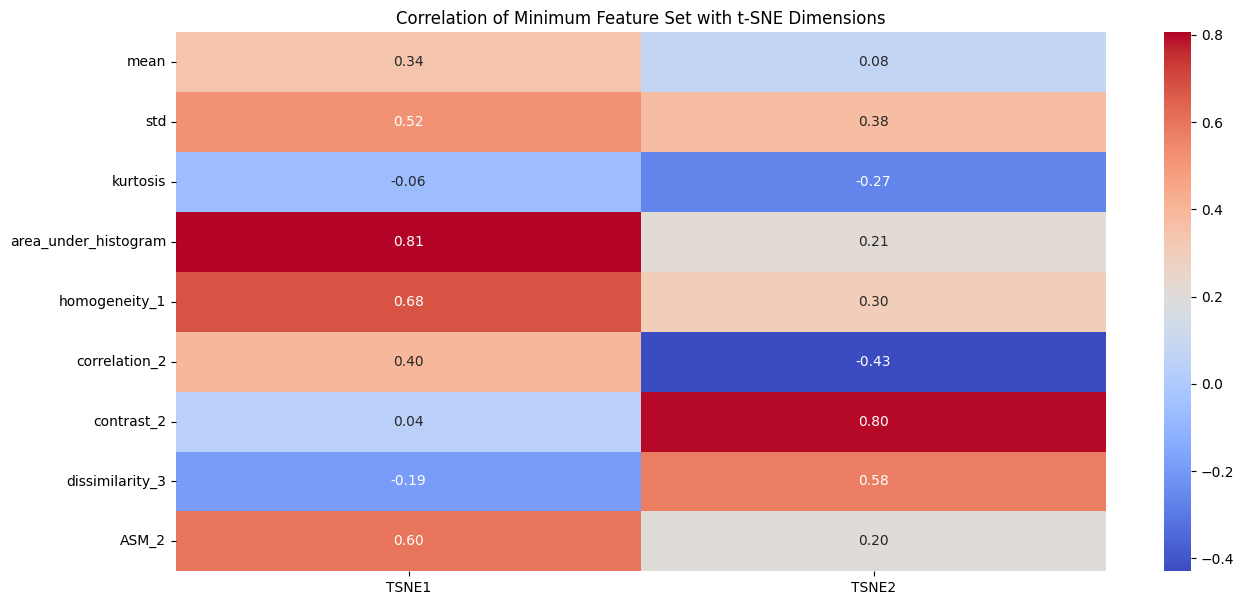

In [7]:
if(stage=='process'):
    correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
    tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
    plt.figure(figsize=(15, 7))
    sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation of Minimum Feature Set with t-SNE Dimensions")
    plt.show()

In [10]:
image_stats_df['vendor'] = image_stats_df['vendor'].replace(['IMS s.r.l.', 'IMS GIOTTO S.p.A.'], 'IMS')
df = image_stats_df.groupby('vendor').sample(n=70)
input_size, num_classes, train_loader, test_loader, le = get_datasets(df)
model, criterion, optimizer = build_model(input_size, num_classes)
train_metrics = train_model(model, optimizer, criterion, train_loader)

 16%|█▌        | 32/200 [00:00<00:04, 37.28it/s]

Early stopping at epoch 33


In [11]:
if(stage=='process'):
    image_stats_df['vendor'] = image_stats_df['vendor'].replace(['IMS s.r.l.', 'IMS GIOTTO S.p.A.'], 'IMS')
    
    acc = []
    f1 = []
    for i in range(100):
        df = image_stats_df.groupby('vendor').sample(n=70)
        _, _, _, test_loader, le = get_datasets(df)
        # model = torch.load('model.pth')
        model = model.eval()
        test_metrics = test_model(model, test_loader)
        acc.append(test_metrics['accuracy'][0])
        f1.append(test_metrics['f1'][0])
    
    test_accuracy = np.mean(acc)
    test_f1 = np.mean(f1)
    
    print(f"Test Metrics - Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}") 


Test Metrics - Accuracy: 0.9324, F1: 0.9324


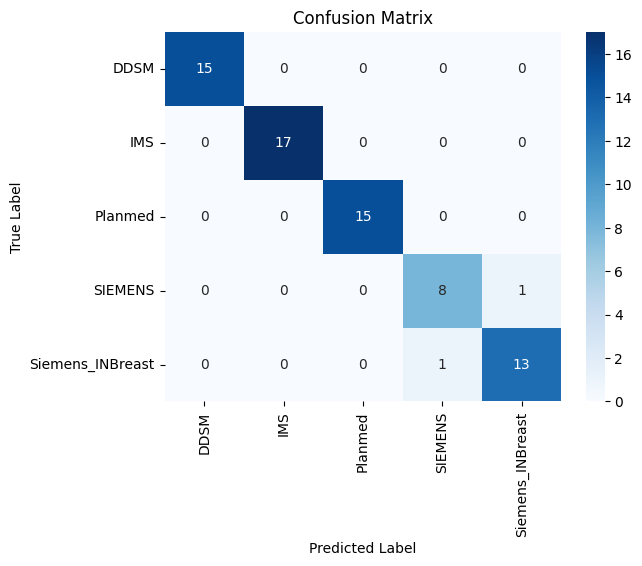

                  precision    recall  f1-score   support

            DDSM       1.00      1.00      1.00        15
             IMS       1.00      1.00      1.00        17
         Planmed       1.00      1.00      1.00        15
         SIEMENS       0.89      0.89      0.89         9
Siemens_INBreast       0.93      0.93      0.93        14

        accuracy                           0.97        70
       macro avg       0.96      0.96      0.96        70
    weighted avg       0.97      0.97      0.97        70



In [14]:
if(stage=='process'):
    plot_cm(model, test_loader, le)

In [198]:
if(stage == 'process'):
    with open('Classification Results/normalized_mild_processing_windows.json', 'w') as json_file:
        json.dump({'accuracy': test_accuracy, 'f1': test_f1}, json_file, indent=4)

In [8]:
image_stats_df.groupby('vendor')[min_features].agg('mean')

,mean,std,kurtosis,area_under_histogram,homogeneity_1,correlation_2,contrast_2,dissimilarity_3,ASM_2
vendor,,,,,,,,,
DDSM,0.510598,0.165676,0.423230,4.085788e+06,0.655262,0.433050,1653.777114,33.351158,0.125771
IMS GIOTTO S.p.A.,0.571063,0.158923,0.150719,2.641554e+06,0.753435,0.616010,1104.591454,29.405450,0.151740
IMS s.r.l.,0.300206,0.250288,8.639647,5.570372e+06,0.709650,0.746028,1267.379007,16.705841,0.325108
Planmed,0.467452,0.136871,0.355128,1.318448e+06,0.052766,0.227437,1712.956422,35.021220,0.000101
SIEMENS,0.277481,0.139247,0.578435,1.624512e+06,0.097485,0.503155,1164.155640,33.553432,0.000121
Siemens_INBreast,0.513007,0.134149,0.388069,2.618864e+06,0.072083,0.419802,1209.777027,31.254131,0.000127


In [13]:
image_stats_df.groupby('vendor')[min_features].agg('mean')

,mean,std,kurtosis,area_under_histogram,homogeneity_1,correlation_2,contrast_2,dissimilarity_3,ASM_2
vendor,,,,,,,,,
DDSM,0.210791,0.248424,-0.359970,1.180848e+07,0.528071,0.843236,1096.284244,28.141076,0.217898
IMS,0.285799,0.279918,6.879323,5.490609e+06,0.657151,0.589361,6776.657882,38.187361,0.279990
Planmed,0.453675,0.158876,32.096000,4.530444e+06,0.759716,0.854061,501.084781,11.783207,0.435294
SIEMENS,0.902614,0.268682,8.431731,4.928255e+06,0.912492,0.391692,4945.858991,21.447905,0.689073
Siemens_INBreast,0.675600,0.443761,-1.129630,5.293977e+06,0.865733,0.879156,3092.817523,26.287307,0.377554


In [12]:
image_stats_df.groupby('vendor')[min_features].agg('mean')

,mean,std,kurtosis,area_under_histogram,homogeneity_1,correlation_2,contrast_2,dissimilarity_3,ASM_2
vendor,,,,,,,,,
DDSM,0.210791,0.248424,-0.359970,1.180848e+07,0.528071,0.843236,1096.284244,28.141076,0.217898
IMS,0.285799,0.279918,6.879323,5.490609e+06,0.657151,0.589361,6776.657882,38.187361,0.279990
Planmed,0.774486,0.247465,-0.436513,4.729998e+06,0.708089,0.895902,799.508918,18.637897,0.433532
SIEMENS,0.910108,0.276091,7.796406,4.926784e+06,0.901586,0.389902,6058.242688,26.275043,0.663008
Siemens_INBreast,0.681412,0.444839,-1.133081,5.295746e+06,0.868172,0.878525,3107.473283,26.315194,0.426651


In [16]:
image_stats_df.groupby('vendor')[min_features].agg('mean')

,mean,std,kurtosis,area_under_histogram,homogeneity_1,correlation_2,contrast_2,dissimilarity_3,ASM_2
vendor,,,,,,,,,
DDSM,0.233949,0.243143,-0.377021,1.140000e+07,0.530548,0.843039,1080.318387,27.714466,0.227152
IMS,0.284928,0.280538,6.881454,5.488400e+06,0.661862,0.596302,6483.901864,37.124360,0.283561
Planmed,0.247114,0.315942,2.579690,4.907369e+06,0.787621,0.266073,9897.806706,46.113765,0.440353
SIEMENS,0.825120,0.357558,1.748150,4.925961e+06,0.923754,0.854720,2292.642881,19.021836,0.583181
Siemens_INBreast,0.475577,0.091096,2.101065,3.492681e+06,0.106816,0.436356,590.968991,21.467782,0.000284


pixel intensity: DDSM, PLANMED, IMS, SIB, SIEMENS
Variance: SIB, DDSM, IMS, PLANMED, SIEMENS
Homogeneity: SIB, DDSM, IMS, PLANMED, SIEMENS
Correlation: PLANMED, SIB, IMS, DDSM, SIEMENS
Contrast: SIB, DDSM, SIEMENS, IMS, PLANMED
Dissimilarity: SIEMENS, SIB, DDSM, IMS, PLANMED
ASM: SIB, DDSM, IMS, PLANMED, SIEMENS

Siemens: Reduce Pixel Intensity, Variance, Homogeneity, Correlation, ASM
         Increase Contrast, Dissimilarity

SIB: Reduce Pixel Intensity
     Increase Variance, Homogeneity,, ASM, Contrast

Planmed: Reduce Contrast, Dissimilarity

DDSM: Increase Homogeneity, ASM, Pixel Intensity

In [ ]:
SIEMENS = 0.9217
Planmed = 0.9433
IMS = 0.8837
DDSM = 0.67
Sample = 0.806

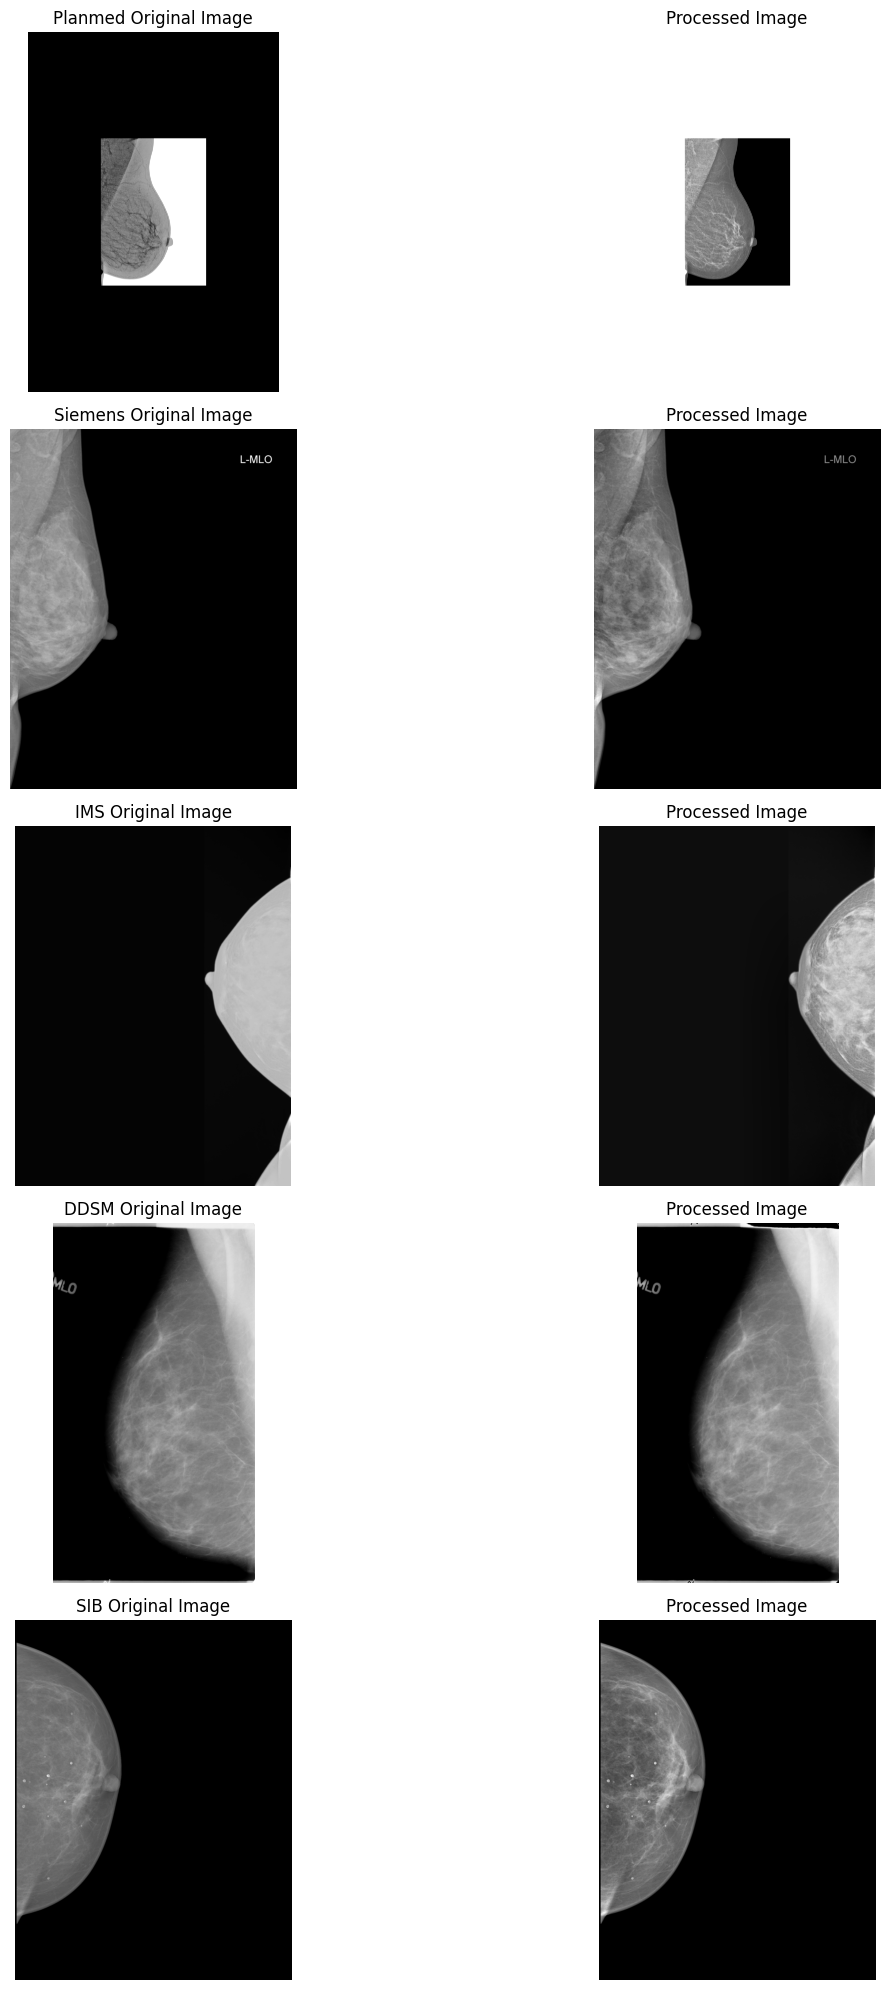

In [131]:
img = pad_image(pydicom.dcmread(image_stats_df.iloc[1600]['file_name']).pixel_array, max_height, max_width)
pro_img = pad_image(process_images(img, image_stats_df.iloc[1600]['vendor']), max_height, max_width)
fig, axes = plt.subplots(5, 2, figsize=(15, 20))  # 1 row, 2 columns
axes[0][0].imshow(img, cmap='gray')
axes[0][0].set_title('Planmed Original Image')
axes[0][0].axis('off')
axes[0][1].imshow(pro_img, cmap='gray')
axes[0][1].set_title('Processed Image')
axes[0][1].axis('off')


img = pydicom.dcmread(image_stats_df.iloc[100]['file_name']).pixel_array
pro_img = process_images(img, image_stats_df.iloc[100]['vendor'])
axes[1][0].imshow(img, cmap='gray')
axes[1][0].set_title('Siemens Original Image')
axes[1][0].axis('off')
axes[1][1].imshow(pro_img, cmap='gray')
axes[1][1].set_title('Processed Image')
axes[1][1].axis('off')

img = pydicom.dcmread(image_stats_df.iloc[2000]['file_name']).pixel_array
pro_img = process_images(img, image_stats_df.iloc[2000]['vendor'])
axes[2][0].imshow(img, cmap='gray')
axes[2][0].set_title('IMS Original Image')
axes[2][0].axis('off')
axes[2][1].imshow(pro_img, cmap='gray')
axes[2][1].set_title('Processed Image')
axes[2][1].axis('off')

img = pydicom.dcmread(image_stats_df.iloc[2100]['file_name']).pixel_array
pro_img = process_images(img, image_stats_df.iloc[2100]['vendor'])
axes[3][0].imshow(img, cmap='gray')
axes[3][0].set_title('DDSM Original Image')
axes[3][0].axis('off')
axes[3][1].imshow(pro_img, cmap='gray')
axes[3][1].set_title('Processed Image')
axes[3][1].axis('off')

img = pydicom.dcmread(image_stats_df.iloc[2600]['file_name']).pixel_array
pro_img = process_images(img, image_stats_df.iloc[2600]['vendor'])
axes[4][0].imshow(img, cmap='gray')
axes[4][0].set_title('SIB Original Image')
axes[4][0].axis('off')
axes[4][1].imshow(pro_img, cmap='gray')
axes[4][1].set_title('Processed Image')
axes[4][1].axis('off')

plt.tight_layout()
plt.show()

